# HackNY: Exploring NYC Buildings with Python

### Just in case: Some resources for Python for analytics

* [Data Analysis with Python and Pandas Video Series](https://www.youtube.com/watch?v=Iqjy9UqKKuo&list=PLQVvvaa0QuDc-3szzjeP6N6b0aDrrKyL-) - *step-by-step videos for getting started, I recommend starting here*

* [Data Science for Social Good Curriculum (UChicago)](https://github.com/dssg/dssg-training-workshop-2015/tree/gh-pages/notebooks) - *fairly comprehensive reference in a 'bootcamp' format*



In [1]:
### path to MODA module
import sys
sys.path.append('code/')

## Open source tools
import pandas as pd
import matplotlib
import seaborn
import folium

## some functions MODA wrote to help automate simple tasks like geocoding
from MODA import GeoHelper


## enabling charts 
%matplotlib inline
matplotlib.style.use('seaborn-talk')


#### Preprocessing of PLUTO data I've already done to save time

PLUTO comes in 5 borough files, which I've combined here. I've also added the building class names to their codes so we can easily see what type of building/s is/are on each lot. 

## Surprisingly Difficult Question: What is a building?

**What aspects define a building?**  
* Structure? (4 walls, a door)?  
* Land it sits on?   
* What if I add an addition?  
* What if I build a new building on top of an [existing one](http://newyorkyimby.com/2016/01/developer-of-711-west-end-avenue-promises-new-amenities-for-rent-stabilized-tenants.html) ?


**To a person, these questions seem obvious or even silly. For data, they are challenging and important to answer when doing analysis.**

* NYC Dept. of Buildings Data [BIS](http://a810-bisweb.nyc.gov/bisweb/bispi00.jsp)
* NYC Dept. of Finance Data [ACRIS](http://a836-acris.nyc.gov/CP/)
* NYC Dept. of City Planning Data [(PLUTO)](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page) 



## What is PLUTO?

Primary Land Use Tax Lot Output (PLUTO!) is published by the Department of City Planning. PLUTO is a record of every lot of land in the city. 

See the Data Dictionary [here](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=16v2)

**Why does the city care to know so much about what's on a lot of land?**




In [2]:
##I've done one bit of prep work that combined all five borough files into a single table. This will load the file
## from a place I've saved it online. It may take 30+ seconds because it is quite large.
PLUTO = pd.read_csv('https://s3.amazonaws.com/modashare/PLUTO_processed.csv')

PLUTO.head()

/home/srimmele/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (19,20,22,23,24,25,26,64,65,77,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,...,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,BUILDING_CATCODE,BUILDING_CLASS
0,0,BK,1,1,302,21.0,NaN,13.0,33.0,11201.0,...,NaN,302 007,30101.0,NaN,3.000010e+09,11/26/2013,1,16V2,V,VACANT LAND
1,1,BK,1,50,302,21.0,2000.0,13.0,33.0,11201.0,...,NaN,302 007,30101.0,E-231,0.000000e+00,NaN,1,16V2,E,WAREHOUSES
2,2,BK,1,7501,302,21.0,2000.0,13.0,33.0,11201.0,...,NaN,302 007,30101.0,NaN,3.000010e+09,3/4/2016,1,16V2,R,CONDOMINIUMS
3,3,BK,3,1,302,21.0,3002.0,13.0,33.0,11201.0,...,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,1,16V2,U,UTILITY BUREAU PROPERTIES
4,4,BK,3,5,302,21.0,NaN,13.0,33.0,11201.0,...,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,4,16V2,T,TRANSPORTATION FACILITIES



## A warm up trivia question: What is the oldest building in NYC? 

[Spoiler](https://en.wikipedia.org/wiki/John_Bowne_House)

In [3]:
## Several buildings have year built '0' so I have to ignore those
PLUTO = PLUTO[PLUTO.YearBuilt >= 1000]


print 'The oldest building in PLUTO was built in ' + str(PLUTO.YearBuilt.min()) 

print 'The address is ' + PLUTO[PLUTO.YearBuilt == PLUTO.YearBuilt.min()].Address

The oldest building in PLUTO was built in 1661
528607    The address is 37-01 BOWNE STREET
Name: Address, dtype: object


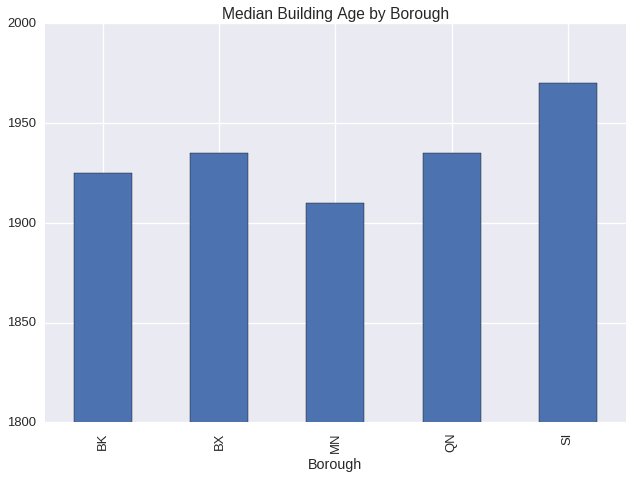

In [4]:
age = PLUTO.groupby('Borough')['YearBuilt'].median().plot(kind = 'bar', title = 'Median Building Age by Borough')
age = age.set_ylim(1800,2000)

## A real problem: Someone has a physical disability and wants to find a place to live in NYC

What are some important considerations?

**Is my building accessible to wheelchairs or other physical needs**?
       
[Fair Housing Act Design and Construction Requirements](https://www.ada.gov/doj_hud_statement.pdf):

> > The Fair Housing Act requires all “covered multifamily dwellings” designed and
constructed for first occupancy after March 13, 1991, to be readily accessible to and
usable by persons with disabilities. In buildings with four or more dwelling units and at
least one elevator, all dwelling units and all public and common use areas are subject to
the Act’s design and construction requirements. In buildings with four or more dwelling
units and no elevator, all ground floor units and public and common use areas are subject
to the Act’s design and construction requirements. 




In [22]:
PLUTO['BUILT_POST_FHA'] = PLUTO.YearBuilt >= 1991
PLUTO['MEETS_FHA_UNIT_THRESH'] = PLUTO.UnitsRes >= 4 # residential units 
PLUTO['LIKELY_ACCESSIBLE'] = (PLUTO.BUILT_POST_ADA) & (PLUTO.MEETS_FHA_UNIT_THRESH)


PLUTO['RESIDENTIAL'] = PLUTO.UnitsRes > 0 

PLUTO[PLUTO.RESIDENTIAL].LIKELY_ACCESSIBLE.value_counts()

False    751602
True       8210
Name: LIKELY_ACCESSIBLE, dtype: int64

## What kind of buildings are most likely to be compliant based on the FHA?

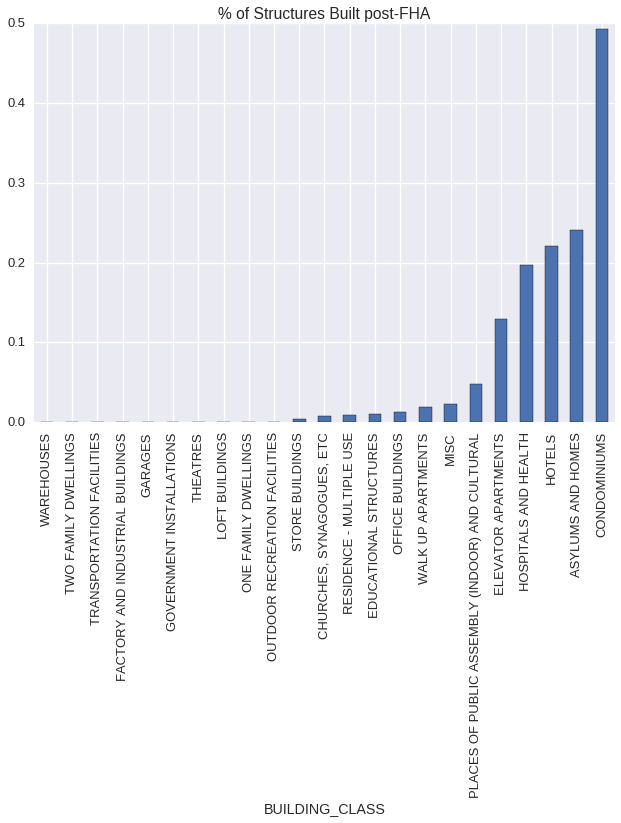

In [24]:
PLUTO[PLUTO.RESIDENTIAL].groupby('BUILDING_CLASS')['LIKELY_ACCESSIBLE'].mean()\
            .sort_values()\
            .plot(kind = 'bar', title = '% of Structures Built post-FHA')

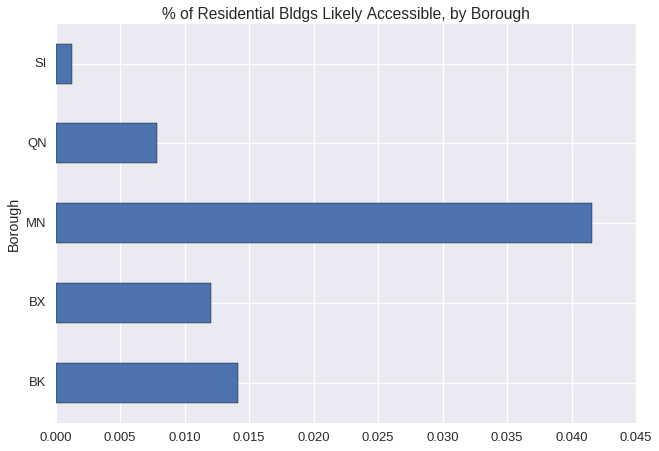

In [31]:
PLUTO[PLUTO.RESIDENTIAL].groupby(['Borough'])['LIKELY_ACCESSIBLE'].mean() \
                .sort_index().plot(kind = 'barh', title = '% of Residential Bldgs Likely Accessible, by Borough')

## Some more considerations

* **Renovations**; buildings are gut-renovated all the time and in some cases will be brought up to accessibility standards


### What about accessible neighborhoods?

It's not just about accessible homes, which neighborhoods in the city have the highest density of accessible:
    * Transit (!!!) 
    * Schools
    * Libraries & Public Facilities
    * Parks
    * Stores / Theaters / Venues / Entertainment
    * Anything else ?
    
    
    

